# Machine Learning

*лектор - Екатерина Лобачева*

*ФЭН ВШЭ программа экономика; Совместный бакалавриат НИУ ВШЭ и РЭШ; 2017-18 учебный год*

[Страница курса](http://math-info.hse.ru/2016-17/Machine_Learning) - ВОЗМОЖНО ТУТ ТОЖЕ ПОНАДОБИТСЯ ПРАВКА

In [1]:
# Пишем заготовку, на которую не будет времени на семинаре. Обе функции строят регрессию и рисуют её.
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
# Регрессия с квадратичной ошибкой
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(-3, 6, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

import statsmodels.api as sm
import statsmodels.formula.api as smf
# Регрессия с асболютной ошибкой (медианная регрессия)
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('y ~ x', pd.DataFrame(data=X_subset, columns=["x", "y"])) # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(-3, 6, 100)
    plt.plot(grid, grid * res.params["x"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

## Семинар 2: градиентный спуск и линейная регрессия

### Матричное дифференцирование
Поскольку мы часто будем работать с матрицей "объекты-признаки" $X$ и поскольку во многих семействах алгоритмов нужно находить оптимальное значение не одного параметра, а целого вектора параметров, то нам нужно кое-что узнать о матричном дифференцировании. Приведем определения: 
##### Производная скаляра $q_{1\times1}$ по вектору $w_{1\times n}$
Пусть есть скаляр $q_{1\times1}$ и вектор-столбец $w_{n\times1}=(w_1,...,w_n)^T$. Существует 2 традиции матричного дифференцирования, суть различия которых заключается в представлении вектора производной — в виде столбца или в виде строки. Мы будем представлять результат дифференцирования в виде столбца:
$$\frac{\partial q}{\partial w}= \begin{pmatrix}
\frac{\partial q}{\partial w_1}\\
\frac{\partial q}{\partial w_2}\\
\vdots\\
\frac{\partial q}{\partial w_n} \\
\end{pmatrix}
.$$


Теперь приведем ряд полезных свойств матричного дифференцирования, которые мы оставим без доказательства. 

1.1) $\frac{\partial a^Tx}{\partial x}=\frac{\partial x^Ta}{\partial x}=a$

1.3) $\frac{\partial x^T Ax}{\partial x} = (A + A^T) x$


(Здесь строчная буква означает вектор, заглавная - матрицу (кроме буквы T, которая означает транспонирование))<br/>
(Тем, кто хочет больше узнать о ключевых моментах матричного дифференцирования, уготована сия [памятка](https://github.com/FilatovArtm/ML_Eco-NES_2017/blob/master/maintain/pamyatka.ipynb))

### Градиентный спуск

Мы знаем, что существует аналитическое решение при подборе оптимальных параметров линейной регрессии. Однако, часто расчёты при использовании аналитического решения для компьютера оказываются довольно сложными (например, при большом числе признаков, описывающих объекты $X$). Градиентный спуск, в этом отношении, выгодная  альтернатива, поскольку сложность (занимаемое время) вычисления градиентного спуска меньше.

Пусть имеется гладкая числовая функция от нескольких аргументов 
$$\begin{align}
f\colon& \mathbb R^n \to \mathbb R\\
f\colon& \omega \mapsto f(\omega), \quad \omega=(\omega_1, \ldots, \omega_n) \in \mathbb R^n
\end{align}$$
и мы хотим численно найти её минимум. Известно, что *вектор градиента*, то есть вектор $\frac{\partial f(\omega)}{\partial \omega}=\left(\frac{\partial f(\omega)}{\partial \omega_1}, \ldots, \frac{\partial f(\omega)}{\partial \omega_n}\right)^T$, компонентами которого являются частные производные функции $f$ по каждой переменной, показывает направление локально наискорейшего подъёма. Противоположный вектор (он называется *антиградиентом*) показывает направление локально наискорейшего спуска. Метод градиентного спуска использует именно эту идею и устроен следующим образом. Возьмём какую-нибудь стартовую точку $\omega^0$ (здесь верхний индекс $0$ — это именно индекс, а не степень). Найдём антиградиент $f$ в точке $\omega^0$. «Спустимся» от точки $\omega^0$ вдоль вектора *антиградиента* на какое-то расстояние. Получим новую точку $\omega^1$. Будем повторять операцию много раз. Иными словами, мы построим последовательность $\{\omega^k\}_{k=0}^\infty$ следующим образом:

$$\omega_{k+1} = \omega_k + \eta_k \left(-\frac{\partial f(\omega)}{\partial \omega}\right)$$

Здесь последовательность $\{\eta_k\}_{k=1}^{\infty}$ задаёт величину шага вдоль вектора антиградиента. Для простоты будем пока считать, что $\eta_k = \eta$ для всех $k$, и $\eta$ — достаточно маленькое положительное число. Разумно ожидать, что пределом последовательности $\{\omega_k\}$ будет локальный минимум функции $f$.

### Реализация градиентного спуска
Реализуем градиентный спуск для простого двумерного примера.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import norm
%matplotlib inline

Рассмотрим функцию $f(x, y)=x^2 + 10 y^2$. Её градиент равен $\frac{\partial f(x, y)}{\partial(x, y)}=(2x, 20y)^T$.

In [3]:
def f(u):
    return u[0] ** 2 + 10 * u[1] ** 2
def Df(u):
    return np.array([2*u[0], 20 * u[1]])

In [4]:
def gradient_descent_simple(f, Df, eta=0.01, steps=20000, initial_point=(-3, 3), 
                            precision=1e-10, xmin=-4, xmax=4, ymin=-3, 
                            ymax=3):
    u_prev = np.array(initial_point)


    X = np.linspace(xmin, xmax, 100)
    Y = np.linspace(ymin, ymax, 100)
    plt.figure(figsize=(6, 6))
    plt.contour(X, Y, [[f(np.array([x, y])) for x in X] for y in Y], 100)# нарисуем линии уровня функции $f$

    points = []
    for i in range(steps):
        points.append(u_prev)
        u_new = u_prev - eta * Df(u_prev)

        if norm(u_new - u_prev) < precision:
            break
        # прекратить, если новая точка достаточно близка к старой

        u_prev = u_new


    plt.plot([p[0] for p in points], [p[1] for p in points], 'o-')
    return points[-1]

array([ -4.94792403e-09,   2.95255661e-97])

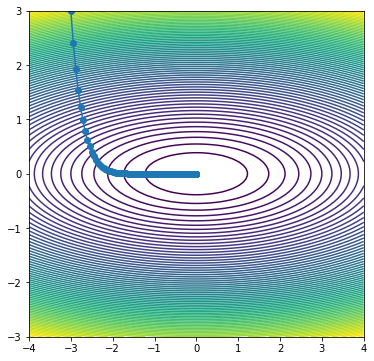

In [5]:
gradient_descent_simple(f=f, Df=Df)

Посмотрим на траекторию изменения значений $w^{(j)}$ по мере того, как $j$ растёт. Как видно, метод градиентного спуска успешно справляется с задачей, устремляя данную траекторию к точке, в которой достигается  минимум функции. Однако, если взять слишком большую $\eta$, то сходимости может и не быть:

array([ -9.88131292e-324,  -3.00000000e+000])

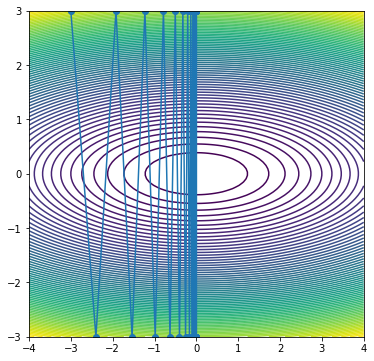

In [6]:
gradient_descent_simple(f=f, Df=Df, eta=0.1)

А если $\eta$ слишком маленькая, то мы можем не успеть дойти до минимума за требуемое количество итераций.

array([-2.99988001,  2.9988003 ])

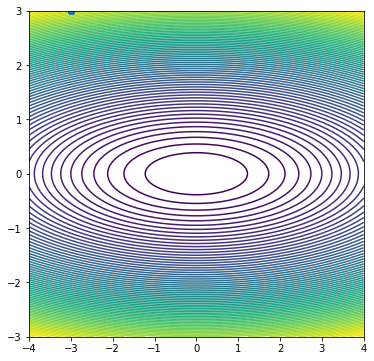

In [7]:
gradient_descent_simple(f=f, Df=Df, eta=1e-9)

Иногда методом градиентого спуска вообще нелья достичь минимума. Известный пример: [функция Розенброка](https://ru.wikipedia.org/wiki/Функция_Розенброка).

### Линейная регрессия
Все понимают, что здесь нарисовано?
![alt text][logo]

[logo]: https://cdn-images-1.medium.com/max/600/1*iuqVEjdtEMY8oIu3cGwC1g.png "Logo Title Text 2"

Пусть мы хотим предсказывать переменную $y$ по значениям $m$ числовых признаков $x_1, \ldots, x_d$ ($d$ как бы dimension). Пусть обучающая выборка состоит из $l$ наблюдений ($l$ как бы learn). Имеющиеся данные можно записать в виде матрицы, каждая строка которой будет соответствовать одному наблюдению, а каждый столбец — одной переменной (всего будет $l$ строк и $d$ столбцов). Обозначим эту матрицу через $X=(x_{ij})$: индексом $i$ будем обозначать номер наблюдения, а $j$ — номер переменной, $i=1, \ldots, l$; $j=1,\ldots, d$. Обозначим $l$-мерный вектор ответов через $y=(y_1,\ldots, y_l)$.

В задаче линейной регрессии мы предполагаем, что ответ нашего алгоритма является линейной функцией от данных, то есть

$$a(x_i)=w_1 x_{i1} + \ldots + w_d x_{id}= \langle x_i, w\rangle,$$

где угловыми скобками обозначается стандартное скалярное произведение, $w=(w_1, \ldots, w_d)$ — вектор весов. Вектор предсказаний для всех объектов выборки можно преставить как произведение матрицы "объекты-признаки" $X$ на вектор весов $w$:

$$
a(X)= Xw =
\begin{pmatrix}
x_{1,1} & x_{1,2} & \ldots & x_{1,d} \\
x_{2,1} & x_{2,2} & \ldots & x_{2,d} \\
\vdots & \vdots & \vdots & \vdots \\
x_{l,1} & x_{l,2} & \ldots & x_{l,d} \\
\end{pmatrix}
\begin{pmatrix}
w_1 \\
w_2 \\
\vdots \\
w_d
\end{pmatrix}
=
\begin{pmatrix}
x_{1,1} w_1 + x_{1,2} w_2 + \ldots + x_{1,d} w_d \\
x_{1,2} w_1 + x_{2,2} w_2 + \ldots + x_{2,d} w_d \\
\vdots
x_{l,1} w_1 + x_{l,2} w_2 + \ldots + x_{l,d} w_d \\
\end{pmatrix}
$$

## Функции потерь в регрессии

*Обучение* модели состоит в нахождении «хорошего» вектора весов $w^*$, для которого отклонения вектора предсказаний $\hat{y}=a(X)$ от настоящего значения $y$ будет «маленьким». Что конкретно подразумевается под малостью отклонения, зависит от функционала качества $Q(a)$. Или иными словами, от типа функции потерь $L(y_i, a(x_i))$) (L как бы loss, Q как бы quality). 

Функционал качества $Q(a)$ в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака для каждого объекта $x_i$. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$. 

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример функции потерь:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и фактом.


### Квадратичная функция потерь
Самым распространенным способом обучения линейной регрессионной модели является метод наименьших квадратов. Это обуславливается многими факторами, например тем, что обучение регрессии в таком случае реализуется несложно как с помощью градиентного спуска, так и аналитически. Или тем, что в эконометрике существует теорема Гаусса-Маркова, которая при определенных предпосылках даёт полученному $w^*$ ряд очень хороших свойств. При использовании этого метода минимизируется *средняя квадратичная ошибка (Mean Squared Error)*:

$$Q(w) = \frac{1}{l}\sum_{i=1}^l L(y_i, a(x_i)) = \frac{1}{l}\sum_{i=1}^l ( \langle x_i, w\rangle - y_i)^2 \rightarrow min$$

Важно не путаться в названиях: функционал качества $Q(.)$ называется средней квадратичной ошибкой (MSE), а функция потерь $L(.,.)$ называется квадратичной функцией потерь. 

Можно представить $Q(w)$ в матричной форме. Вектор ошибок вычисляется как $Xw-y$. Поэтому квадратичная функция потерь $Q(w)$ записывается в виде:

$$Q(w) = \frac{1}{l}\|Xw-y\|^2 = \frac{1}{l}\langle Xw-y, Xw-y \rangle = \frac{1}{l}(Xw-y)^T (Xw-y).$$

Чтобы применить градиентный спуск к функции $Q$, нужно посчитать её градиент. Для этого понадобятся свойства матричного дифференцирования, с которыми мы немного ознакомились в начале семинара. Содержательно в этом нет ничего особо сложного, но если вы раньше не сталкивались с таким формализмом, может потребоваться некоторое время, чтобы к нему привыкнуть.

### Градиент квадратичной функции потерь
Запишем $Q(w)$ в следующем виде:

$$Q(w) =(Xw-y)^T (Xw-y) = ((Xw)^T-y^T) (Xw-y)= (Xw)^T Xw - y^T Xw - (Xw)^T y + y^T y = w^T X^T X w - y^T Xw - w^T X^T y+ y^T y.$$

Заметим, что $y^T Xw=(y^T Xw)^T = w^T X^T y$ (мы использовали тот факт, что число не меняется при транспонировании). Таким образом,

$$Q(w) = w^T X^T X w - 2 y^T X w+ y^T y.$$

При этом $X^T X$ — симметричная матрица (попробуйте её транспонировать!). Теперь воспользуемся ранее приведенными утверждениями матричного дифференцирования для нахождения градиента $Q$. Имеем:

$$\frac{\partial Q(w)}{\partial w} = 2 X^T X w - 2 (y^T X)^T = 2 X^T X w - 2 X^T y.$$

Для обработки первого слагаемого мы воспользовались свойством 1.3 (подставив $A=X^T X$ и воспользовавшись тем, что $A^T = A$), а для обработки второго — свойством 1.1 (подставив $a = y^T X$).

Теперь всё готово к тому, чтобы применить метод градиентного спуска к функции $Q$. Для простоты визуализации результата рассмотрим простейшую парную линейную регрессию. Например, представьте себе, что мы измеряем зависимость роста человека от его веса.

$$y_i = kx_i + b, \quad w=(k, b)$$
Тогда матрица "объекты-признаки" имеет вид:
$$ X= \begin{pmatrix}
x_{1} &1 \\
x_{2} &1 \\
\vdots & \vdots\\
x_{l}& 1 \\
\end{pmatrix} $$
Вектор истинных значений роста всех людей, попавших в выборку, имеет вид:

$$ y= \begin{pmatrix}
y_{1}  \\
y_{2}  \\
\vdots \\
y_{l} \\
\end{pmatrix} $$

Вектор предсказанных значений роста для всех людей, в зависимости от $w$, будет иметь вид:

$$a(X)= Xw = \begin{pmatrix}
x_{1} &1 \\
x_{2} &1 \\
\vdots & \vdots\\
x_{l}& 1 \\
\end{pmatrix} 
\begin{pmatrix}
k \\
b\\
\end{pmatrix}$$

Сгенерируем данные. Особенно над реализмом мы заморачиваться не будем, представим себе, что измеряем вес и рост лунных лилипутов. Главное, что мы имеем дело с парной регрессией:

In [8]:
from numpy.random import normal

In [9]:
n = 100
x = normal(size=n)
y = 3 + 2 * x + normal(size=n)

Здесь было сгенерировано 100 нормально $x$'ов, взятых из стандартного нормального распределения, a $y$ вычислялись так: честная линейная функция плюс шум (также взятый из стандартного нормального распределения).

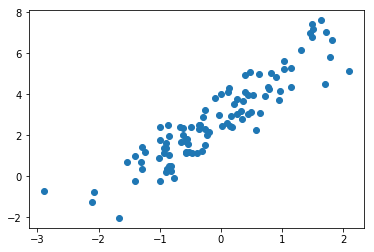

In [10]:
# посмотрим, что у нас за данные
plt.plot(x, y, 'o')

Запишем теперь матрицу $X$.

In [11]:
X = np.array([x, np.ones_like(x)]).T
X[:10]

array([[-0.90528797,  1.        ],
       [-1.41089467,  1.        ],
       [ 0.11964579,  1.        ],
       [-0.99597617,  1.        ],
       [ 1.70203324,  1.        ],
       [-0.86403265,  1.        ],
       [-0.57247046,  1.        ],
       [ 1.03428183,  1.        ],
       [-0.89455138,  1.        ],
       [-1.00426158,  1.        ]])

Поскольку наша регрессия имеет свободный член, к матрице $X$ нужно приписать столбец, состоящий из одних единиц. В данном случае мы использовали функцию `np.ones_like()`, генерирующую объект с такими же измерениями, как и его аргумент, заполненный единицами. Иными словами, мы попросили сделать вектор такой же длины, как $x$, но заполненный единицами. `np.array` в данном случае создаёт матрицу из списка списков, считая, что она записана по строкам; чтобы её записать по столбцам, мы применили транспонирование.

Запишем квадратичную функцию потерь и её градиент.

In [12]:
def Q(w):
    S = X @ w - y
    return S.T @ S

In [13]:
def DQ(w):
    return 2 * (X.T @ X @ w - X.T @ y)

array([ 1.92749462,  2.92542969])

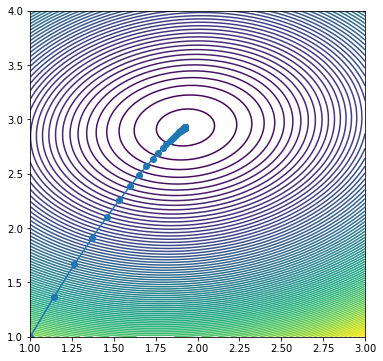

In [14]:
gradient_descent_simple(f=Q, Df=DQ, xmin=1, xmax=3, ymin=1, ymax=4, 
                        initial_point=(1, 1), eta=0.001)

Как видим, получается результат, похожий на настоящие значения $k$ и $b$.

### Средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [15]:
X_subset = pd.DataFrame({'x':x,'y':y}).values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

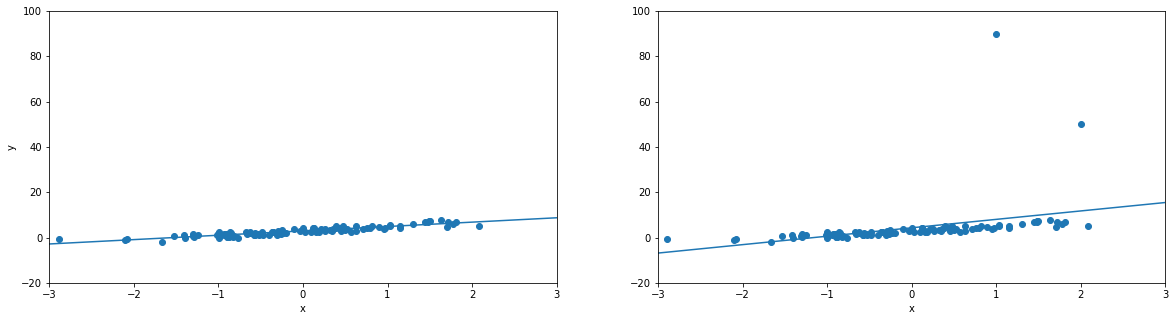

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
#эту функцию мы написали заблаговременно, она строит и рисует регрессию
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlim(-3,3)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlim(-3,3)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: 

$$L(y_i, a(x_i)) = |a(x_i) - y_i|$$

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

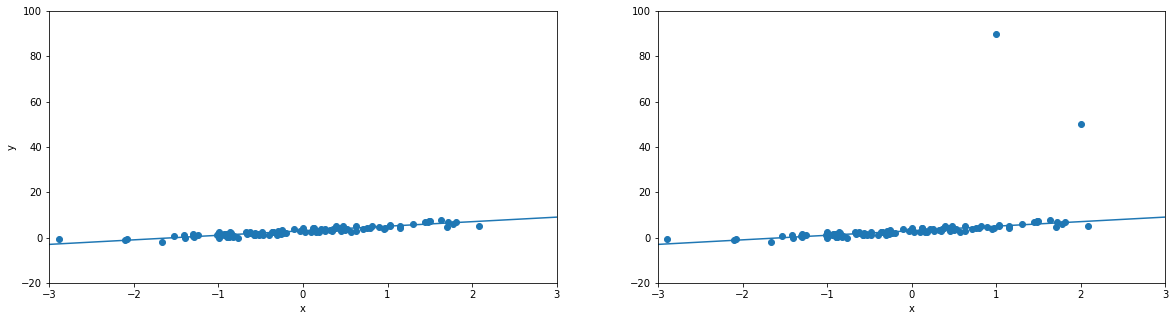

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlim(-3,3)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlim(-3,3)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов. Попробуем добавить больше шумовых объектов:

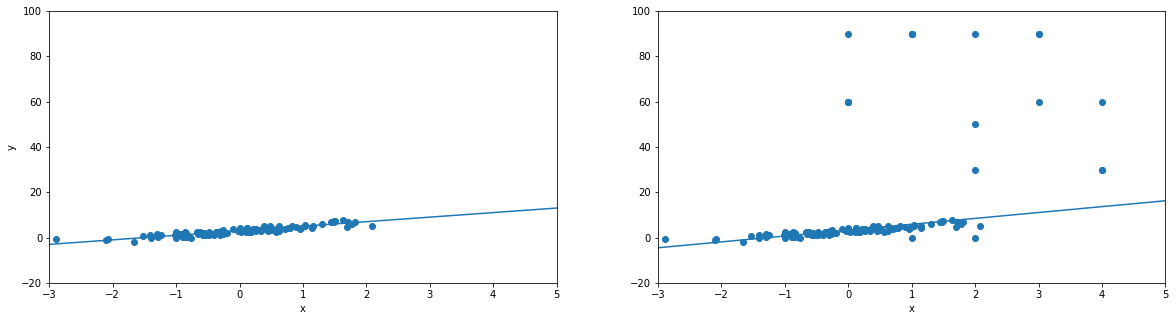

In [18]:
# добавление двух шумовых точек
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=40).reshape(-1, 2)*[1, 30]))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlim(-3,5)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlim(-3,5)
plt.xlabel("x")

Прямая немного изменила наклон, когда мы добавили 20 (20%, так как в у нас 100 объектов до этого было в выборке) шумовых точек. Подобная устойчивость к выбросам и обуславливает некоторую популярность MAE.

Почему так происходит? Рассмотрим некоторые свойства MSE и MAE.

Пусть алгоритм возвращает константный ответ: $a(x) = C$. Такие алгоритмы используются, когда для одного объекта известны несколько различных значений одного целевого признака (например, суммы покупок в одном магазине).

__Задача.__ Найдите $C$, минимизирующий среднеквадратичную ошибку.

_Решение._ $$C = \frac 1 \ell \sum_{i=1}^\ell y_i = \bar{y}$$.

__Задача.__ Найдите $C$, минимизирующий среднюю абсолютную ошибку.

_Решение._ 

Минимум MAE достигается при $C = median(y_1, \dots, y_\ell) = m.$ 

Поскольку средняя абсолютная ошибка не является дифференцируемой по $w$ функцией, оптимизировать ее напрямую методом градиентного спуска не удастся. Аналитическое решение - также заслуживает особого рассмотрения, хотя не такое уж оно и сложное. Графический смысл медианной регрессии достаточно прост: МАE так проводит прямую на графике, что половина объектов находится выше этой прямой, а другая половина - ниже. Чтобы убедиться, построим регрессию для небольшого числа объектов в нашей выборке лилипутов:

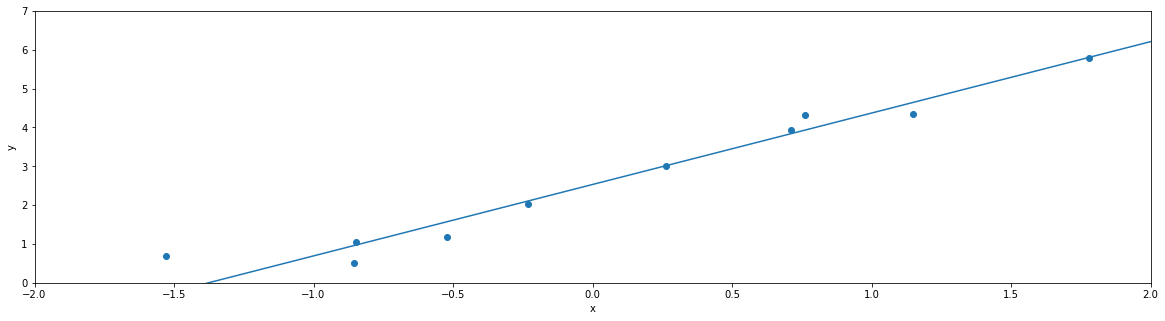

In [19]:
plt.figure(figsize=(20, 5))
model, result = scatter_points_and_plot_line_MAE(X_subset[10:20])
plt.ylim(-0, 7)
plt.xlim(-2, 2)

plt.xlabel("x")
plt.ylabel("y")

### Huber Loss
Иногда используют "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значени целевого признака - Huber Loss:
$$L(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Легко проверить, что у этой функции существует непрерывная первая производная во всех точках.

Оптимизация Huber Loss реализована в sklearn:

In [20]:
from sklearn.linear_model import HuberRegressor

### Quantile Loss

В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, для крупных ретейлерских сетей лучше предсказать потребительский спрос больше, чем будет по факту, чем меньше, потому что в первом случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(z) = \begin{cases} \tau z, \quad z > 0, \\ (\tau - 1) z, \quad z \leqslant 0 \end{cases}$$
Параметр $\tau$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

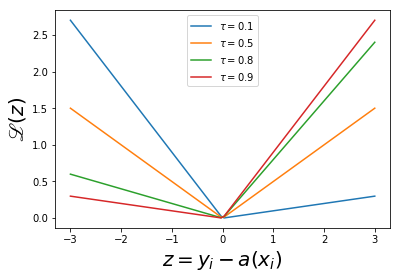

In [21]:
grid = np.linspace(-3, 3, 100)
tau_list = [0.1, 0.5, 0.8, 0.9]
for tau in tau_list:
    plt.plot(grid, tau * grid * (grid > 0) + (tau - 1) * grid * (grid <= 0), label=r"$\tau = " + str(tau) + r"$")
plt.xlabel(r'$z = y_i - a(x_i)$', size=20)
plt.ylabel(r'$\mathscr{L}(z)$', size=20)
plt.legend(loc=0)

Изобразим график квантильной функции потерь вместе с другими рассмотренными:

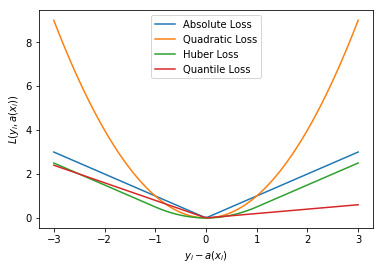

In [22]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (grid <= 0)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.xlabel("$y_i - a(x_i)$")
plt.ylabel("$L(y_i, a(x_i))$")
plt.legend()

__Задача.__ Укажите параметр $\tau$, при котором обучение квантильной регрессии равносильно оптимизации MAE.

_Решение._ При $\tau = \frac 1 2$ $$\rho_\tau(x) = \frac 1 2 |x|$$ и $L(y_i, a(x_i)) = \frac 1 2 MAE$.

Проследим наклон прямой в нашей одномерной задаче регрессии при изменении $\tau$ для небольшого числа объектов (n):

C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


(-3, 3)

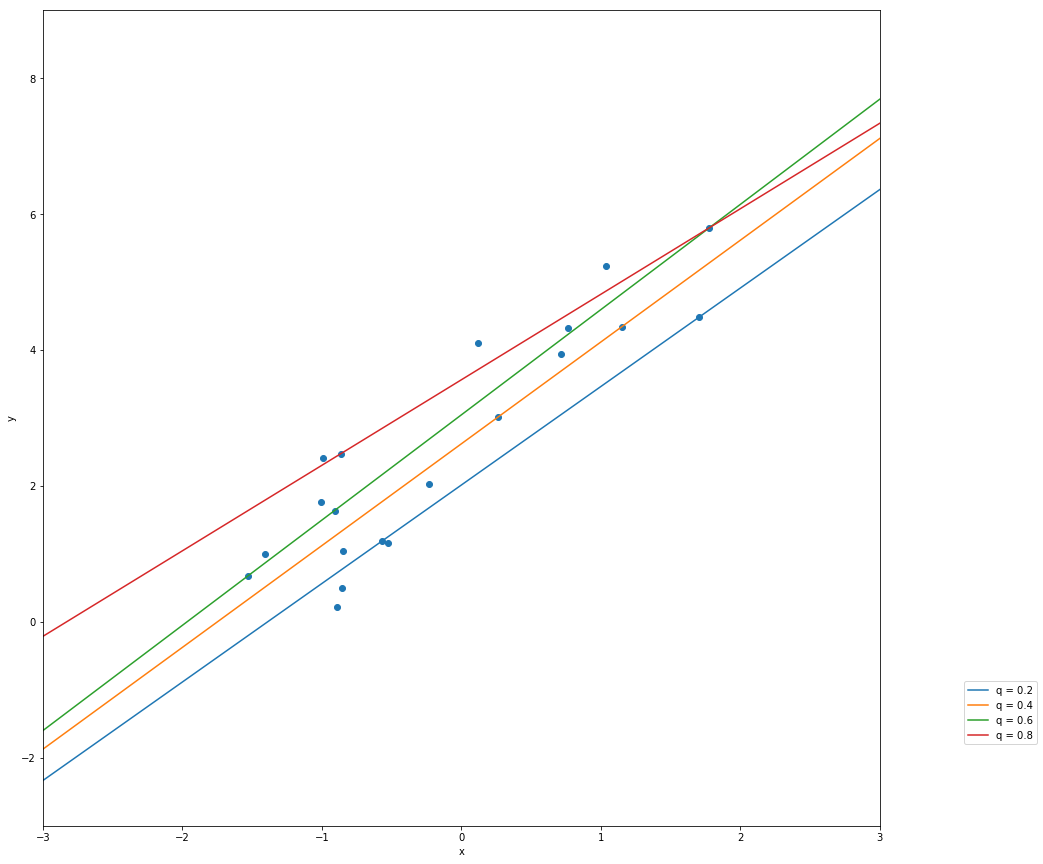

In [23]:
plt.figure(figsize=(15,15))
# число объектов
n = 20
plt.scatter(X_subset[:n, 0], X_subset[:n, 1])
grid = np.linspace(-4, 6, 100)
mod = smf.quantreg('y ~ x', pd.DataFrame(data=X_subset[:n], columns=["x", "y"]))
for q in np.arange(0.2, 1, 0.2):
    res = mod.fit(q=q)
    plt.plot(grid, grid * res.params["x"] + res.params["Intercept"], label="q = "+str(q))
plt.legend(loc=(1.1, 0.1))
plt.xlabel("x")
plt.ylabel("y")

plt.ylim(-3, 9)
plt.xlim(-3, 3)


На графике видно, почему такая регрессия называется квантильной: проведенная прямая разделяет объекты в выборке в пропорции $q$  - снизу, и $1-q$ - сверху. Таким образом, между всеми нарисованными прямыми на графике находится одинаковое количество точек.